# Feature transformation with Amazon SageMaker processing job and Feature Store

### Introduction

Start with the raw [Women's Clothing Reviews](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews) dataset and prepare it to train a BERT-based natural language processing (NLP) model. The model will be used to classify customer reviews into positive (1), neutral (0) and negative (-1) sentiment.

You will convert the original review text into machine-readable features used by BERT. To perform the required feature transformation you will configure an Amazon SageMaker processing job, which will be running a custom Python script.

### Table of Contents

- [1. Configure the SageMaker Feature Store](#c2w1-1.)
  - [1.1. Configure dataset](#c2w1-1.1.)
  - [1.2. Configure the SageMaker feature store](#c2w1-1.2.)
- [2. Transform the dataset](#c2w1-2.)
    - [Exercise 2](#c2w1-ex-2)
    - [Exercise 3](#c2w1-ex-3)
- [3. Query the Feature Store](#c2w1-3.)
  - [3.1. Export training, validation, and test datasets from the Feature Store](#c2w1-3.1.)
  - [3.2. Export TSV from Feature Store](#c2w1-3.2.)
  - [3.3. Check that the dataset in the Feature Store is balanced by sentiment](#c2w1-3.3.)


In [1]:
# please ignore warning messages during the installation
!pip install --disable-pip-version-check -q sagemaker==2.35.0
!conda install -q -y pytorch==1.6.0 -c pytorch
!pip install --disable-pip-version-check -q transformers==3.5.1

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytorch==1.6.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2021.7.5   |       h06a4308_1         113 KB
    certifi-2021.5.30          |   py37h06a4308_0         139 KB
    cudatoolkit-10.2.89        |       hfd86e86_1       365.1 MB
    ninja-1.10.2               |       hff7bd54_1         1.4 MB
    pytorch-1.6.0              |py3.7_cuda1

In [2]:
import boto3
import sagemaker
import botocore

#config = botocore.config.Config(user_agent_extra='dlai-pds/c2/w1')

# low-level service client of the boto3 session
sm = boto3.client(service_name='sagemaker') #, config=config)

featurestore_runtime = boto3.client(service_name='sagemaker-featurestore-runtime') #, config=config)

sess = sagemaker.Session(sagemaker_client=sm,
                         sagemaker_featurestore_runtime_client=featurestore_runtime)

bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = sess.boto_region_name
print('S3 Bucket: {}'.format(bucket))
print('Region: {}'.format(region))
print('Role: {}'.format(role))

S3 Bucket: sagemaker-eu-north-1-295482097746
Region: eu-north-1
Role: arn:aws:iam::295482097746:role/service-role/AmazonSageMaker-ExecutionRole-20210729T105826


<a name='c2w1-1.'></a>
# 1. Configure the SageMaker Feature Store

<a name='c2w1-1.1.'></a>
### 1.1. Configure dataset
The raw dataset is (already) in the sessions S3 bucket. Let's start by specifying the S3 location of it:

In [5]:
raw_input_data_s3_uri = 's3://{}/data/raw/'.format(bucket)
print(raw_input_data_s3_uri)

s3://sagemaker-eu-north-1-295482097746/data/raw/


List the files in the S3 bucket (in this case it will be just one file):

In [6]:
!aws s3 ls $raw_input_data_s3_uri

2021-07-31 09:28:06    8457214 womens_clothing_ecommerce_reviews.csv


<a name='c2w1-1.2.'></a>
### 1.2. Configure the SageMaker feature store

As the result of the transformation, in addition to generating files in S3 bucket, you will also save the transformed data in the **Amazon SageMaker Feature Store** to be used by others in your organization, for example. 

To configure a Feature Store you need to setup a **Feature Group**. This is the main resource containing all of the metadata related to the data stored in the Feature Store. A Feature Group should contain a list of **Feature Definitions**. A Feature Definition consists of a name and the data type. The Feature Group also contains an online store configuration and an offline store configuration controlling where the data is stored. Enabling the online store allows quick access to the latest value for a record via the [GetRecord API](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_feature_store_GetRecord.html). The offline store allows storage of the data in your S3 bucket. You will be using the offline store in this lab.

Let's setup the Feature Group name and the Feature Store offline prefix in S3 bucket (you will use those later in the lab):

In [7]:
import time
timestamp = int(time.time())

feature_group_name = 'reviews-feature-group-' + str(timestamp)
feature_store_offline_prefix = 'reviews-feature-store-' + str(timestamp)

print('Feature group name: {}'.format(feature_group_name))
print('Feature store offline prefix in S3: {}'.format(feature_store_offline_prefix))

Feature group name: reviews-feature-group-1628019828
Feature store offline prefix in S3: reviews-feature-store-1628019828


Taking two features from the original raw dataset (`Review Text` and `Rating`), you will transform it preparing to be used for the model training and then to be saved in the Feature Store. Here you will define the related features to be stored as a list of `FeatureDefinition`.

In [9]:
from sagemaker.feature_store.feature_definition import (
    FeatureDefinition,
    FeatureTypeEnum,
)

feature_definitions= [
    # unique ID of the review
    FeatureDefinition(feature_name='review_id', feature_type=FeatureTypeEnum.STRING), 
    # ingestion timestamp
    FeatureDefinition(feature_name='date', feature_type=FeatureTypeEnum.STRING),
    # sentiment: -1 (negative), 0 (neutral) or 1 (positive). It will be found the Rating values (1, 2, 3, 4, 5)
    FeatureDefinition(feature_name='sentiment', feature_type=FeatureTypeEnum.STRING), 
    # label ID of the target class (sentiment)
    FeatureDefinition(feature_name='label_id', feature_type=FeatureTypeEnum.STRING),
    # reviews encoded with the BERT tokenizer
    FeatureDefinition(feature_name='input_ids', feature_type=FeatureTypeEnum.STRING),
    # original Review Text
    FeatureDefinition(feature_name='review_body', feature_type=FeatureTypeEnum.STRING),
    # train/validation/test label
    FeatureDefinition(feature_name='split_type', feature_type=FeatureTypeEnum.STRING)
]


Create the feature group using the feature definitions defined above.


In [10]:
from sagemaker.feature_store.feature_group import FeatureGroup

feature_group = FeatureGroup(
    name=feature_group_name,
    feature_definitions=feature_definitions,
    sagemaker_session=sess
)

print(feature_group)

FeatureGroup(name='reviews-feature-group-1628019828', sagemaker_session=<sagemaker.session.Session object at 0x7f5858c3f510>, feature_definitions=[FeatureDefinition(feature_name='review_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='date', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='sentiment', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='label_id', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='input_ids', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='review_body', feature_type=<FeatureTypeEnum.STRING: 'String'>), FeatureDefinition(feature_name='split_type', feature_type=<FeatureTypeEnum.STRING: 'String'>)])


You will use the defined Feature Group later in this lab, the actual creation of the Feature Group will take place in the processing job. Now let's move into the setup of the processing job to transform the dataset.

<a name='c2w1-2.'></a>
# 2. Transform the dataset

Configure a SageMaker processing job to run a custom Python script to balance and transform the raw data into a format used by BERT model.

Set the transformation parameters including the instance type, instance count, and train/validation/test split percentages. For the purposes of this lab, you will use a relatively small instance type. Please refer to [this](https://aws.amazon.com/sagemaker/pricing/) link for additional instance types that may work for your use case outside of this lab.

You can also choose whether you want to balance the dataset or not. In this case, balance the dataset to avoid class imbalance in the target variable, `sentiment`. 

Another important parameter of the model is the `max_seq_length`, which specifies the maximum length of the classified reviews for the RoBERTa model. If the sentence is shorter than the maximum length parameter, it will be padded. In another case, when the sentence is longer, it will be truncated from the right side.

Since a smaller `max_seq_length` leads to faster training and lower resource utilization, you want to find the smallest power-of-2 that captures `100%` of our reviews.  For this dataset, the `100th` percentile is `115`.  However, it's best to stick with powers-of-2 when using BERT. So let's choose `128` as this is the smallest power-of-2 greater than `115`. You will see below how the shorter sentences will be padded to a maximum length.


```
mean        52.512374
std         31.387048
min          1.000000
10%         10.000000
20%         22.000000
30%         32.000000
40%         41.000000
50%         51.000000
60%         61.000000
70%         73.000000
80%         88.000000
90%         97.000000
100%       115.000000
max        115.000000
```

![](images/distribution_num_words_per_review.png)


In [11]:
processing_instance_type='ml.c5.xlarge'
processing_instance_count=1
train_split_percentage=0.90
validation_split_percentage=0.05
test_split_percentage=0.05
balance_dataset=True
max_seq_length=128

To balance and transform our data, use a scikit-learn-based processing job. This is essentially a generic Python processing job with scikit-learn pre-installed. You can specify the version of scikit-learn you wish to use. Also pass the SageMaker execution role, processing instance type and instance count.

In [12]:
from sagemaker.sklearn.processing import SKLearnProcessor

processor = SKLearnProcessor(
    framework_version='0.23-1',
    role=role,
    instance_type=processing_instance_type,
    instance_count=processing_instance_count,
    env={'AWS_DEFAULT_REGION': region},                             
    max_runtime_in_seconds=7200
)

The processing job will be running the Python code from the file `src/prepare_data.py`.


Complete method `encode_plus` of the RoBERTa `tokenizer`. Pass the `max_seq_length` as a value for the argument `max_length`. It defines a pad to a maximum length specified.

### _This cell will take approximately 1-2 minutes to run._

In [13]:
import sys, importlib
sys.path.append('src/')

# import the `prepare_data.py` module
import prepare_data

# reload the module if it has been previously loaded 
if 'prepare_data' in sys.modules:
    importlib.reload(prepare_data)

input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)
    
updated_correctly = False

if len(input_ids) != max_seq_length:
    print('#######################################################################################################')
    print('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
    print('#######################################################################################################')
    raise Exception('Please check that the function \'convert_to_bert_input_ids\' in the file src/prepare_data.py is complete.')
else:
    print('##################')
    print('Updated correctly!')
    print('##################')

    updated_correctly = True


##################
Updated correctly!
##################


Review the results of tokenization for the given example (*\"this product is great!\"*):

In [14]:
input_ids = prepare_data.convert_to_bert_input_ids("this product is great!", max_seq_length)

print(input_ids)
print('Length of the sequence: {}'.format(len(input_ids)))

[0, 9226, 1152, 16, 372, 328, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Length of the sequence: 128


Launch the processing job with the custom script passing defined above parameters.

In [15]:
from sagemaker.processing import ProcessingInput, ProcessingOutput

if (updated_correctly):

    processor.run(code='src/prepare_data.py',
              inputs=[
                    ProcessingInput(source=raw_input_data_s3_uri,
                                    destination='/opt/ml/processing/input/data/',
                                    s3_data_distribution_type='ShardedByS3Key')
              ],
              outputs=[
                    ProcessingOutput(output_name='sentiment-train',
                                     source='/opt/ml/processing/output/sentiment/train',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-validation',
                                     source='/opt/ml/processing/output/sentiment/validation',
                                     s3_upload_mode='EndOfJob'),
                    ProcessingOutput(output_name='sentiment-test',
                                     source='/opt/ml/processing/output/sentiment/test',
                                     s3_upload_mode='EndOfJob')
              ],
              arguments=['--train-split-percentage', str(train_split_percentage),
                         '--validation-split-percentage', str(validation_split_percentage),
                         '--test-split-percentage', str(test_split_percentage),
                         '--balance-dataset', str(balance_dataset),
                         '--max-seq-length', str(max_seq_length),                         
                         '--feature-store-offline-prefix', str(feature_store_offline_prefix),
                         '--feature-group-name', str(feature_group_name)                         
              ],
              logs=True,
              wait=False)

else:
    print('#######################################')
    print('Please update the code correctly above.')
    print('#######################################')    


Job Name:  sagemaker-scikit-learn-2021-08-03-20-06-03-648
Inputs:  [{'InputName': 'input-1', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/data/raw/', 'LocalPath': '/opt/ml/processing/input/data/', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'ShardedByS3Key', 'S3CompressionType': 'None'}}, {'InputName': 'code', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/input/code/prepare_data.py', 'LocalPath': '/opt/ml/processing/input/code', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'sentiment-train', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-train', 'LocalPath': '/opt/ml/processing/output/sentiment/train', 'S3UploadMode': 'EndOfJob'}}, {'

You can see the information about the processing jobs using the `describe` function. The result is in dictionary format. Let's pull the processing job name:

In [16]:
scikit_processing_job_name = processor.jobs[-1].describe()['ProcessingJobName']

print('Processing job name: {}'.format(scikit_processing_job_name))

Processing job name: sagemaker-scikit-learn-2021-08-03-20-06-03-648



Pull the processing job status from the processing job description.


In [17]:
print(processor.jobs[-1].describe().keys())

dict_keys(['ProcessingInputs', 'ProcessingOutputConfig', 'ProcessingJobName', 'ProcessingResources', 'StoppingCondition', 'AppSpecification', 'Environment', 'RoleArn', 'ProcessingJobArn', 'ProcessingJobStatus', 'LastModifiedTime', 'CreationTime', 'ResponseMetadata'])


In [24]:
scikit_processing_job_status = processor.jobs[-1].describe()['ProcessingJobStatus']
print('Processing job status: {}'.format(scikit_processing_job_status))

Processing job status: Completed


Review the created processing job in the AWS console.

**Instructions**: 
- open the link
- notice that you are in the section `Amazon SageMaker` -> `Processing jobs`
- check the name of the processing job, its status and other available information

In [19]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/sagemaker/home?region={}#/processing-jobs/{}">processing job</a></b>'.format(region, scikit_processing_job_name)))

Wait for about 5 minutes to review the CloudWatch Logs. You may open the file [src/prepare_data.py](src/prepare_data.py) again and examine the outputs of the code in the CloudWatch logs.

In [20]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://console.aws.amazon.com/cloudwatch/home?region={}#logStream:group=/aws/sagemaker/ProcessingJobs;prefix={};streamFilter=typeLogStreamPrefix">CloudWatch logs</a> after about 5 minutes</b>'.format(region, scikit_processing_job_name)))

After the completion of the processing job you can also review the output in the S3 bucket.

In [21]:
from IPython.core.display import display, HTML

display(HTML('<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/{}/{}/?region={}&tab=overview">S3 output data</a> after the processing job has completed</b>'.format(bucket, scikit_processing_job_name, region)))


Wait for the processing job to complete.

### _This cell will take approximately 15 minutes to run._

In [25]:
%%time

running_processor = sagemaker.processing.ProcessingJob.from_processing_name(
    processing_job_name=scikit_processing_job_name,
    sagemaker_session=sess
)

running_processor.wait(logs=False)

!CPU times: user 10.6 ms, sys: 4.33 ms, total: 15 ms
Wall time: 61.1 ms


_Please wait until ^^ Processing Job ^^ completes above_

Inspect the transformed and balanced data in the S3 bucket.

In [26]:
processing_job_description = running_processor.describe()

output_config = processing_job_description['ProcessingOutputConfig']
for output in output_config['Outputs']:
    if output['OutputName'] == 'sentiment-train':
        processed_train_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-validation':
        processed_validation_data_s3_uri = output['S3Output']['S3Uri']
    if output['OutputName'] == 'sentiment-test':
        processed_test_data_s3_uri = output['S3Output']['S3Uri']
        
print(processed_train_data_s3_uri)
print(processed_validation_data_s3_uri)
print(processed_test_data_s3_uri)

s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-train
s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-validation
s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-test


In [27]:
!aws s3 ls $processed_train_data_s3_uri/

2021-08-03 20:19:27    4892752 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [28]:
!aws s3 ls $processed_validation_data_s3_uri/

2021-08-03 20:19:27     278646 part-algo-1-womens_clothing_ecommerce_reviews.tsv


In [29]:
!aws s3 ls $processed_test_data_s3_uri/

2021-08-03 20:19:27     269282 part-algo-1-womens_clothing_ecommerce_reviews.tsv


Copy the data into the folder `balanced`.

In [30]:
!aws s3 cp $processed_train_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./data/balanced/sentiment-train/
!aws s3 cp $processed_validation_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./data/balanced/sentiment-validation/
!aws s3 cp $processed_test_data_s3_uri/part-algo-1-womens_clothing_ecommerce_reviews.tsv ./data/balanced/sentiment-test/

download: s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv to data/balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv to data/balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv
download: s3://sagemaker-eu-north-1-295482097746/sagemaker-scikit-learn-2021-08-03-20-06-03-648/output/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv to data/balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv


Review the training, validation and test data outputs:

In [31]:
!head -n 5 ./data/balanced/sentiment-train/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
3193	-1	0	[0, 100, 2162, 5, 6399, 11, 28079, 8, 439, 159, 10, 1836, 228, 5, 2949, 31, 97, 34910, 4, 99, 939, 197, 33, 626, 21, 213, 159, 132, 10070, 328, 1237, 1307, 328, 127, 1623, 26, 939, 1415, 5283, 8, 14, 18, 393, 10, 205, 356, 114, 110, 45, 4, 1051, 42, 124, 5, 276, 183, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I bought the shirt in ivory and went down a size per the advice from other reviewers. what i should have done was go down 2 sizes! runs huge! my husband said i looked pregnant and that's never a good look if your not. sent this back the same day.	2021-08-03T20:13:54Z
17750	-1	0	[0, 133, 13657, 1326, 15898, 15, 5, 1421, 142, 79, 11224, 69, 3701, 136, 5, 5418, 4, 7, 127, 2755, 1437, 1437, 5, 13657, 888, 16, 182, 182, 182, 910, 1021, 1021, 475, 1423

In [32]:
!head -n 5 ./data/balanced/sentiment-validation/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
7695	1	2	[0, 1779, 939, 78, 1381, 24, 15, 1437, 939, 21, 3915, 24, 74, 1606, 158, 12, 996, 23246, 7, 127, 1946, 19487, 5120, 1437, 53, 114, 10610, 12461, 1437, 24, 888, 34, 10, 34203, 1437, 11875, 7059, 1683, 4, 939, 5940, 2498, 24, 490, 36, 3341, 11, 5, 1345, 43, 19, 5, 276, 1907, 9, 7490, 12213, 734, 13724, 29, 182, 15391, 328, 50, 1437, 7, 492, 2512, 10, 6533, 13977, 1437, 304, 5, 1286, 21041, 7494, 3016, 7, 5, 526, 50, 304, 110, 308, 739, 1437, 445, 7494, 4, 67, 1326, 372, 19, 12669, 17510, 328, 5, 10199, 1318, 64, 75, 28, 1451, 4, 24, 18, 2579, 8, 2016, 7, 5, 2842, 4, 939, 6056, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	When i first tried it on  i was worried it would add 10-15 lbs to my hourglass frame  but if worn correctly  it actually has a flattering  slimming effect. i recommend wearing it open (like in the photo) with the same type of outfit underneath...looks very chic! or  to give yourself a defined waist  use the provided

In [33]:
!head -n 5 ./data/balanced/sentiment-test/part-algo-1-womens_clothing_ecommerce_reviews.tsv

review_id	sentiment	label_id	input_ids	review_body	date
11749	1	2	[0, 100, 524, 195, 108, 134, 113, 8, 5962, 17243, 19, 23739, 8, 14357, 4, 939, 524, 5262, 8, 11875, 53, 939, 33, 326, 359, 10, 11, 2292, 4216, 1437, 10, 2631, 438, 8, 10, 12172, 53, 4, 14, 26, 4, 42, 3588, 156, 162, 356, 6764, 8, 6474, 700, 4, 939, 362, 5, 3023, 29, 4716, 1459, 142, 5, 3023, 29, 5, 21997, 21, 350, 251, 15, 5, 2576, 4, 89, 16, 2710, 9, 3089, 11556, 15, 5, 299, 7, 9824, 5, 22, 26778, 113, 8, 47, 64, 2999, 5, 3588, 62, 50, 159, 7, 146, 24, 55, 3089, 47482, 50, 55, 9, 10, 15898, 6730, 3588, 1437, 7, 110, 12832, 4, 24, 18, 55, 9, 41, 28608, 28079, 3195, 8, 2721, 19, 1637, 50, 4334, 2]	"I am 5'1"" and 120lb with curves and muscles. i am tiny and slim but i have t & a in spades  a 34c and a bubble but. that said. this dress made me look tall and lithe. i took the xs petite because the xs the fringe was too long on the bottom. there is plenty of blouse on the top to accommodate the ""girls"" and you can pull the

<a name='c2w1-3.'></a>
# 3. Query the Feature Store
In addition to transforming the data and saving in S3 bucket, the processing job populates the feature store with the transformed and balanced data.  Let's query this data using Amazon Athena.

<a name='c2w1-3.1.'></a>
### 3.1. Export training, validation, and test datasets from the Feature Store

Export only for the training dataset, as an example. 

Use `athena_query()` function to create an Athena query for the defined above Feature Group. Then you can pull the table name of the Amazon Glue Data Catalog table which is auto-generated by Feature Store.

In [34]:
feature_store_query = feature_group.athena_query()

feature_store_table = feature_store_query.table_name

query_string = """
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "{}" 
    WHERE split_type='train' 
    LIMIT 5
""".format(feature_store_table)

print('Glue Catalog table name: {}'.format(feature_store_table))
print('Running query: {}'.format(query_string))

Glue Catalog table name: reviews-feature-group-1628019828-1628021604
Running query: 
    SELECT date,
        review_id,
        sentiment, 
        label_id,
        input_ids,
        review_body
    FROM "reviews-feature-group-1628019828-1628021604" 
    WHERE split_type='train' 
    LIMIT 5



Configure the S3 location for the query results.  This allows us to re-use the query results for future queries if the data has not changed.  We can even share this S3 location between team members to improve query performance for common queries on data that does not change often.

In [35]:
output_s3_uri = 's3://{}/query_results/{}/'.format(bucket, feature_store_offline_prefix)
print(output_s3_uri)

s3://sagemaker-eu-north-1-295482097746/query_results/reviews-feature-store-1628019828/



Query the feature store.


In [36]:
feature_store_query.run(
    query_string=query_string,
    output_location=output_s3_uri
)

feature_store_query.wait()

In [37]:
import pandas as pd
pd.set_option("max_colwidth", 100)

df_feature_store = feature_store_query.as_dataframe()
df_feature_store

,date,review_id,sentiment,label_id,input_ids,review_body
0,2021-08-03T20:13:54Z,3193,-1,0,"[0, 100, 2162, 5, 6399, 11, 28079, 8, 439, 159, 10, 1836, 228, 5, 2949, 31, 97, 34910, 4, 99, 93...",I bought the shirt in ivory and went down a size per the advice from other reviewers. what i sho...
1,2021-08-03T20:13:54Z,7283,-1,0,"[0, 100, 98, 770, 7, 657, 42, 6013, 1437, 8, 21, 98, 2283, 7, 120, 24, 11, 5, 7107, 328, 939, 30...",I so wanted to love this tank and was so excited to get it in the mail! i got a size small (my ...
2,2021-08-03T20:13:54Z,1883,0,1,"[0, 713, 3588, 2037, 127, 2295, 804, 8, 939, 56, 7, 33, 24, 4, 77, 24, 2035, 24, 21, 202, 95, 25...",This dress caught my eye online and i had to have it. when it arrived it was still just as prett...
3,2021-08-03T20:13:54Z,6745,-1,0,"[0, 4993, 2600, 5, 986, 1551, 1437, 939, 21, 1256, 3230, 11, 12926, 42, 3588, 4, 24, 2035, 11, 5...",After reading the previous review i was pretty confident in ordering this dress. it arrived in ...
4,2021-08-03T20:13:54Z,18173,1,2,"[0, 34256, 9, 1765, 24, 2933, 12339, 12, 61, 1437, 965, 75, 2933, 1437, 53, 14, 18, 2051, 142, 9...",Short of calling it dark gray- which isn't dark but that's fine because i saw the picture. it'...


Review the Feature Store in SageMaker Studio

<-- Left pane

<a name='c2w1-3.2.'></a>
### 3.2. Export TSV from Feature Store

Save the output as a TSV file:

In [38]:
df_feature_store.to_csv('./feature_store_export.tsv',
                        sep='\t',
                        index=False,
                        header=True)

In [39]:
!head -n 5 ./feature_store_export.tsv

date	review_id	sentiment	label_id	input_ids	review_body
2021-08-03T20:13:54Z	3193	-1	0	[0, 100, 2162, 5, 6399, 11, 28079, 8, 439, 159, 10, 1836, 228, 5, 2949, 31, 97, 34910, 4, 99, 939, 197, 33, 626, 21, 213, 159, 132, 10070, 328, 1237, 1307, 328, 127, 1623, 26, 939, 1415, 5283, 8, 14, 18, 393, 10, 205, 356, 114, 110, 45, 4, 1051, 42, 124, 5, 276, 183, 4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]	I bought the shirt in ivory and went down a size per the advice from other reviewers. what i should have done was go down 2 sizes! runs huge! my husband said i looked pregnant and that's never a good look if your not. sent this back the same day.
2021-08-03T20:13:54Z	7283	-1	0	[0, 100, 98, 770, 7, 657, 42, 6013, 1437, 8, 21, 98, 2283, 7, 120, 24, 11, 5, 7107, 328, 939, 300, 10, 1836, 650, 36, 4783, 4505, 43, 8, 24, 2075, 98, 

Upload TSV to the S3 bucket:

In [40]:
!aws s3 cp ./feature_store_export.tsv s3://$bucket/feature_store/feature_store_export.tsv

upload: ./feature_store_export.tsv to s3://sagemaker-eu-north-1-295482097746/feature_store/feature_store_export.tsv


Check the file in the S3 bucket:

In [41]:
!aws s3 ls --recursive s3://$bucket/feature_store/feature_store_export.tsv

2021-08-03 20:32:35       4788 feature_store/feature_store_export.tsv


<a name='c2w1-3.3.'></a>
### 3.3. Check that the dataset in the Feature Store is balanced by sentiment

Now you can setup an Athena query to check that the stored dataset is balanced by the target class `sentiment`.


Write an SQL query to count the total number of the reviews per `sentiment` stored in the Feature Group.


In [43]:
feature_store_query_2 = feature_group.athena_query()

query_string_count_by_sentiment = """
SELECT sentiment, COUNT(*) AS count_reviews
FROM "{}"
GROUP BY sentiment
""".format(feature_store_table)


Query the feature store.


In [44]:
feature_store_query_2.run(
    query_string=query_string_count_by_sentiment,
    output_location=output_s3_uri
)

feature_store_query_2.wait()

df_count_by_sentiment = feature_store_query_2.as_dataframe()
df_count_by_sentiment

,sentiment,count_reviews
0,1,2051
1,0,2051
2,-1,2051



Visualize the result of the query in the bar plot, showing the count of the reviews by sentiment value.


<AxesSubplot:xlabel='sentiment', ylabel='count_reviews'>

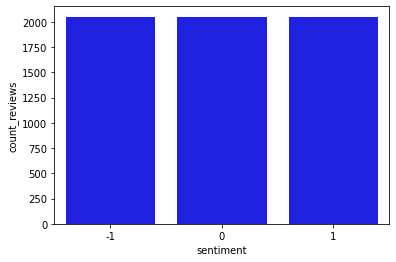

In [45]:
import seaborn as sns

sns.barplot(
    data=df_count_by_sentiment,
    x='sentiment',
    y='count_reviews',
    color="blue"
)